In [1]:
# Standard Library Imports
from __future__ import print_function
from time import time
import os
import gc

# Third-Party Library Imports
import numpy as np
import pandas as pd
import warnings
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import auc, roc_curve

# Keras and TensorFlow Imports
from keras.preprocessing.image import img_to_array, load_img
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Activation, Flatten, Input, Conv2D, MaxPooling2D, BatchNormalization
from keras.regularizers import l1_l2
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K

In [2]:
img_rows = 224
img_cols = 224
if K.image_data_format() == 'channels_first':
    input_shape = (1, img_rows, img_cols)
else:
    input_shape = (img_rows, img_cols, 1)

In [3]:
df = pd.read_csv('xrays1_6.csv')
df.head()

,Image Index,Patient Age,Patient Gender,No_Finding,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Infiltration,Mass,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
0,00000001_000.png,58,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0
1,00000001_001.png,58,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0
2,00000001_002.png,58,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0
3,00000002_000.png,81,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
4,00000003_000.png,81,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [4]:
df['No_Finding'].value_counts()

No_Finding
1    31160
0    23836
Name: count, dtype: int64

In [5]:
use_nofind = True
'''if use_nofind:
    no_find_idx = df.index[df['No_Finding']==1].to_list()
    num = int(0.8 * len(no_find_idx))
    np.random.seed(42)
    no_find_drops = np.random.choice(no_find_idx, size=num, replace=False)
    df.drop(index=no_find_idx,inplace=True)
else:
    df = df[df['No_Finding']!=1]
    df.drop('No_Finding',axis=1,inplace=True)'''
df.head()

,Image Index,Patient Age,Patient Gender,No_Finding,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Infiltration,Mass,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
0,00000001_000.png,58,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0
1,00000001_001.png,58,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0
2,00000001_002.png,58,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0
3,00000002_000.png,81,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
4,00000003_000.png,81,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [6]:
print(df.columns)
print(df.shape)

Index(['Image Index', 'Patient Age', 'Patient Gender', 'No_Finding',
       'Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion',
       'Emphysema', 'Fibrosis', 'Infiltration', 'Mass', 'Nodule',
       'Pleural_Thickening', 'Pneumonia', 'Pneumothorax'],
      dtype='object')
(54996, 17)


In [7]:
labels = ['No_Finding', 'Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema',
       'Effusion', 'Emphysema', 'Fibrosis', 'Infiltration', 'Mass', 'Nodule',
       'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']
labels = ['No_Finding']

In [8]:
image_folder = 'D:\\Downloads\\xrays\\images' # Folder containing the images
image_size = (224, 224, 1)  # Assuming images are resized to (224, 224)
norm_img_path = 'img_1_6.npy'
y = df[labels].values

'''if not os.path.exists(norm_img_path):
    X = []
    for image_filename in df['Image Index']:
        img_path = os.path.join(image_folder, image_filename)
        img = load_img(img_path, color_mode='grayscale')
        img = img_to_array(img)
        X.append(img / 255)
    X = np.array(X)
    np.save(norm_img_path,X)

    del X
    gc.collect()'''

"if not os.path.exists(norm_img_path):\n    X = []\n    for image_filename in df['Image Index']:\n        img_path = os.path.join(image_folder, image_filename)\n        img = load_img(img_path, color_mode='grayscale')\n        img = img_to_array(img)\n        X.append(img / 255)\n    X = np.array(X)\n    np.save(norm_img_path,X)\n\n    del X\n    gc.collect()"

In [9]:
def load_and_process_images(df, image_folder, y):
    batch_size = 32  # Adjust the batch size as needed

    num_images = len(df)
    num_batches = num_images // batch_size
    if num_images % batch_size != 0:
        num_batches += 1

    X = []
    for batch_index in range(num_batches):
        start_index = batch_index * batch_size
        end_index = min((batch_index + 1) * batch_size, num_images)
        batch_X = []

        for image_filename in df['Image Index'].iloc[start_index:end_index]:
            img_path = os.path.join(image_folder, image_filename)
            img = load_img(img_path, color_mode='grayscale')
            img = img_to_array(img)
            batch_X.append(img / 255)

        batch_X = np.array(batch_X)
        X.append(batch_X)
    try:
        X = np.concatenate(X, axis=0)
    except MemoryError:
        print('Memory Error occured during training')
        del X
        gc.collect()
        
    x_train, x_val, y_train, y_val = train_test_split(
        X, y,
        test_size=0.3,
        random_state=42
    )

    return x_train, x_val, y_train, y_val

In [10]:
if not os.path.exists(norm_img_path):
    x_train, x_val, y_train, y_val = load_and_process_images(
        df, 
        image_folder,
        y)
else:
    x_train, x_val, y_train, y_val = train_test_split(
        np.load(norm_img_path), 
        y, 
        test_size=0.3, 
        random_state=42)

Memory Error occured during training


UnboundLocalError: cannot access local variable 'X' where it is not associated with a value

In [ ]:

x_val, x_test, y_val, y_test = train_test_split(
    x_val,
    y_val,
    test_size=0.5,
    stratify=y_val,
    random_state=42
)

In [ ]:
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    fill_mode='nearest'
)

In [ ]:
'''opt = Adam(learning_rate=0.0005)
epochs = 20
batch_size = 16

model.compile(
    optimizer=opt,
    loss='binary_crossentropy', 
    metrics=['binary_accuracy'])

training_time = time()
history = model.fit(
    datagen.flow(x_train, y_train, batch_size=batch_size), 
    epochs=epochs, 
    validation_data=(x_val, y_val), 
    callbacks=[early_stopping, model_checkpoint, reduce_lr])
training_time = training_time - time()
'''

"opt = Adam(learning_rate=0.0005)\nepochs = 20\nbatch_size = 16\n\nmodel.compile(\n    optimizer=opt,\n    loss='binary_crossentropy', \n    metrics=['binary_accuracy'])\n\ntraining_time = time()\nhistory = model.fit(\n    datagen.flow(x_train, y_train, batch_size=batch_size), \n    epochs=epochs, \n    validation_data=(x_val, y_val), \n    callbacks=[early_stopping, model_checkpoint, reduce_lr])\ntraining_time = training_time - time()\n"

In [ ]:
class ImageDataLoader:
    def __init__(self, image_folder, datagen, image_size=(224, 224, 3), batch_size=32):
        self.image_folder = image_folder
        self.image_size = image_size
        self.batch_size = batch_size
        self.datagen = datagen

    def load_and_augment_images(self, df):
        X = []
        num_images = len(df)
        for i in range(0, num_images, self.batch_size):
            print(f'{i}/{num_images}')
            batch_images = []
            for image_filename in df['Image Index'].iloc[i:i+self.batch_size]:
                img_path = self.image_folder + image_filename
                img = load_img(img_path, target_size=image_size)
                img = img_to_array(img)
                batch_images.append(img / 255.0)
            batch_images = np.array(batch_images)

            augmented_images = []
            for batch_img in batch_images:
                augmented_img = self.datagen.random_transform(batch_img)
                augmented_images.append(augmented_img)
            augmented_images = np.array(augmented_images)

            if len(X) == 0:
                X = augmented_images
            else:
                X = np.vstack((X, augmented_images))
        
        return X

In [ ]:
'''opt = Adam(learning_rate=0.0005)
epochs = 20
batch_size = 32

data_loader = ImageDataLoader(
    image_folder=image_folder, 
    datagen=datagen, 
    image_size=input_shape, 
    batch_size=batch_size)
X = data_loader.load_and_augment_images(df)
y = df[labels].values
x_train, x_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)'''

'opt = Adam(learning_rate=0.0005)\nepochs = 20\nbatch_size = 32\n\ndata_loader = ImageDataLoader(\n    image_folder=image_folder, \n    datagen=datagen, \n    image_size=input_shape, \n    batch_size=batch_size)\nX = data_loader.load_and_augment_images(df)\ny = df[labels].values\nx_train, x_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)'

In [ ]:
def plot_loss_acc(values,model_name='Model'):
    labels = ['loss','accuracy']
    colors = ['#1f77b4', '#2ca02c']
    plt.figure(figsize=(5,1.2))
    plt.table(cellText=[[labels[0],"{:.4f}".format(values[0])], [labels[1], "{:.2%}".format(values[1])]],
            colWidths=[0.8, 0.8],
            cellLoc='center',
            loc='center',
            cellColours=[['lightgrey', colors[0]], ['lightgrey', colors[1]]])
    plt.title(model_name+' Loss and Accuracy',y=0.7)
    plt.axis('off')
    plt.tight_layout() 

def plot_loss_accuracy(history,  metric_acc='accuracy'):
    fig = plt.figure(figsize=(12, 6))
    ax = fig.add_subplot(1, 2, 1)
    ax.plot(history.history["loss"],'r-x', label="Train Loss")
    ax.plot(history.history["val_loss"],'b-x', label="Validation Loss")
    ax.legend()
    ax.set_title('Cross Entropy Loss')
    ax.grid(True)


    ax = fig.add_subplot(1, 2, 2)
    ax.plot(history.history[metric_acc],'r-x', label="Train Accuracy")
    ax.plot(history.history['val_'+metric_acc],'b-x', label="Validation Accuracy")
    ax.legend()
    ax.set_title('Accuracy')
    ax.grid(True)

def display_roc(roc_auc , fpr, tpr, class_num, model_name=''):
    plt.figure(figsize=(10, 6))
    for i in range(class_num):
        plt.plot(fpr[i], tpr[i], lw=2, label='ROC curve (class {}) (AUC = {:.2f})'.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')                                                                                                                   
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve of {}'.format(model_name))
    plt.legend(loc="lower right")
    plt.show()

def plot_multiclass_roc(model, x, y, class_num, model_name='', show=True):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    y_pred = model.predict(x).astype('float32')
    print(y.shape)
    print(y_pred.shape)
    for i in range(class_num):
        fpr[i], tpr[i], _ = roc_curve(y[:,i], y_pred[:,i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    if show:    display_roc(roc_auc,fpr,tpr,class_num,model_name)
    else: return roc_auc

In [ ]:
l1_penalty = 0.0001
l2_penalty = 0.0001
model_name = 'xray_model1_6'
model = Sequential(name=model_name)

#Input
model.add(Input(shape=input_shape))

#Conv1
model.add(Conv2D(32, (5, 5), strides=(1,1), activation='relu', padding='same', kernel_regularizer=l1_l2(l1=l1_penalty,l2=l2_penalty)))
model.add(BatchNormalization())

#MaxPool1
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.3))

#Conv2
model.add(Conv2D(64, (5, 5), strides=(1,1), activation='relu', padding='same', kernel_regularizer=l1_l2(l1=l1_penalty,l2=l2_penalty)))
model.add(BatchNormalization())
#MaxPool2
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.3))

#Conv3
model.add(Conv2D(128, (5, 5), strides=(1,1), activation='relu', padding='same', kernel_regularizer=l1_l2(l1=l1_penalty,l2=l2_penalty)))
model.add(BatchNormalization())

#MaxPool3
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.3))

#Conv4
model.add(Conv2D(256, (5, 5), strides=(1,1), activation='relu', padding='same', kernel_regularizer=l1_l2(l1=l1_penalty,l2=l2_penalty)))
model.add(BatchNormalization())

#MaxPool4
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.3))

#Flatten
model.add(Flatten())

#Final Classification
model.add(Dropout(0.5))
model.add(Dense(len(labels)))
model.add(Activation('sigmoid'))

model.summary()



Model: "xray_model1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 32)      832       
                                                                 
 batch_normalization (Batch  (None, 224, 224, 32)      128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 112, 112, 32)      0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 112, 112, 32)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 64)      51264     
                                                                 
 batch_normalization_1 (Bat  (None, 112, 112, 64)    

In [ ]:
opt = Adam(learning_rate=0.0001)
epochs = 50
batch_size = 32
acc_metric = 'binary_accuracy'

early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience=3, 
    verbose=1, 
    restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.5, 
    patience=1, 
    min_lr=0.000001)
model_checkpoint = ModelCheckpoint(
    filepath=model_name+'.keras', 
    monitor='val_'+acc_metric, 
    save_best_only=True, 
    verbose=1)



In [ ]:
model.compile(
    optimizer=opt,
    loss='binary_crossentropy', 
    metrics=[acc_metric])

try:
    flow = datagen.flow(x_train, y_train, batch_size=batch_size)
    training_time = time()
    history = model.fit(
        flow, 
        epochs=epochs, 
        validation_data=(x_val, y_val),
        callbacks=[early_stopping, model_checkpoint, reduce_lr])
    training_time = time() - training_time
except MemoryError:
    print("Memory Error occurred during training.")
    del history
    del model
    gc.collect()

Epoch 1/50


 34/123 [=======>......................] - ETA: 10:17 - loss: 3.0805 - accuracy: 0.5237

: 

: 

13/13 [==============================] - 58s 4s/step
(385, 3)
(385, 3)


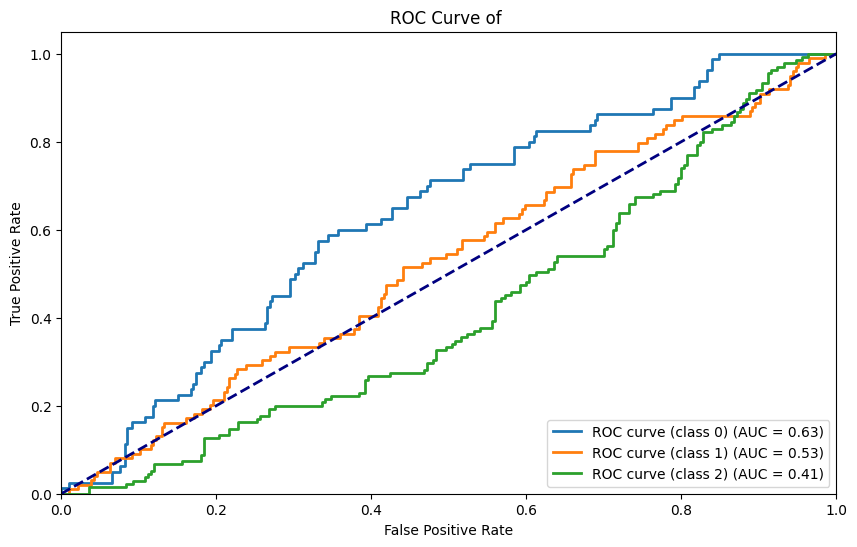

In [ ]:
plot_multiclass_roc(model,x_test,y_test,len(labels))

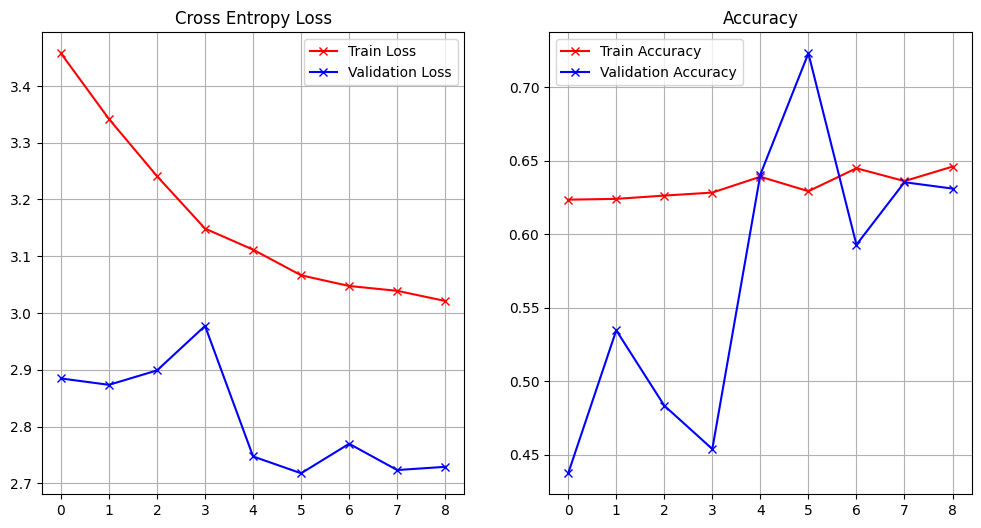

In [ ]:
plot_loss_accuracy(history,acc_metric)

In [ ]:
'''from keras.applications import resnet50

resnet50_model = resnet50.ResNet50(weights='imagenet')'''

"from keras.applications import resnet50\n\nresnet50_model = resnet50.ResNet50(weights='imagenet')"